# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [15]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [16]:
# Note: BatchCustomDataset and loss_fn are defined in the code cells below.

from common_utils import MLP, split_dataset

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train, y_train, X_test, y_test = split_dataset(df, 'filename', 0.30, 1)

class BatchCustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
X_train = X_train.drop(columns=['label'])
X_test = X_test.drop(columns=['label'])

3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [17]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    batch_sizes = parameters
    
    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}

    for batch_size in batch_sizes:
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []
    
    for train_idx, val_idx in cv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        standard_scaler = preprocessing.StandardScaler()
        X_train_fold_scaled = standard_scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = standard_scaler.fit_transform(X_val_fold)
        
        for batch_size in batch_sizes:
            X_train_scaled_dict[batch_size].append(X_train_fold_scaled)
            X_val_scaled_dict[batch_size].append(X_val_fold_scaled)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [128,256,512,1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)


4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [18]:
def intialise_loaders_batch(X_train_scaled, y_train, X_test_scaled, y_test, batch_size):

    train_data = BatchCustomDataset(X_train_scaled,y_train)

    test_data = BatchCustomDataset(X_test_scaled,y_test)
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    return train_dataloader, test_dataloader

def train_loop_batch(dataloader, model, loss_fn, optimizer, x_test, y_test):

    acc_ = []

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = model(torch.tensor(x_test, dtype=torch.float))

        acc__ = (pred.argmax(1) == torch.tensor(y_test, dtype=torch.float)).type(torch.float).mean()
        
        acc_.append(acc__.item())
        
    return acc_

def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    model = MLP(77,128,2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    
    cross_validation_times = []

    foldaccuracyofabatchsize = []
    timeforafoldforthatbatchsize = []
    meanaccuracyofabatchsizelist = []
    meantimeofabatchsizelist = []
    for batch_size in batch_sizes:

        foldaccuracyofabatchsize = []
        timeforafoldforthatbatchsize = []
        for idxy in range(0,5):
            x_train = X_train_scaled_dict[batch_size][idxy]
            y_train = y_train_dict[batch_size][idxy]
            x_test = X_val_scaled_dict[batch_size][idxy]
            y_test = y_val_dict[batch_size][idxy]

            train_dataloader, test_dataloader = intialise_loaders_batch(x_train, y_train, x_test, y_test, batch_size)

            for epoch in range(100):
                start = time.time()
                acc_ = train_loop_batch(train_dataloader, model, loss_fn, optimizer, x_test, y_test)
                end = time.time()
                # for a fold, the list of accuracies for the batches of that epoch^

                if epoch==99:
                    foldaccuracyofabatchsize.append(np.mean(np.array(acc_), axis = 0))
#                     the accuracy for the last epoch of that fold - the fold accuracy for that batch size, length is 5
                    timeforafoldforthatbatchsize.append(end-start)
        meanaccuracyofabatchsizelist.append(np.mean(np.array(foldaccuracyofabatchsize), axis = 0))
        meantimeofabatchsizelist.append(np.mean(np.array(timeforafoldforthatbatchsize), axis = 0))
        # length should be 4^
        
    cross_validation_accuracies = meanaccuracyofabatchsizelist
    cross_validation_times = meantimeofabatchsizelist
    print(cross_validation_accuracies)
    print(cross_validation_times)
    return cross_validation_accuracies, cross_validation_times

batch_sizes = [128,256,512,1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes)


[0.8262322949913313, 0.92106885821731, 0.9488008098942892, 0.9637733561652049]
[4.402658748626709, 2.4930707931518556, 1.7321653366088867, 1.537085723876953]


5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

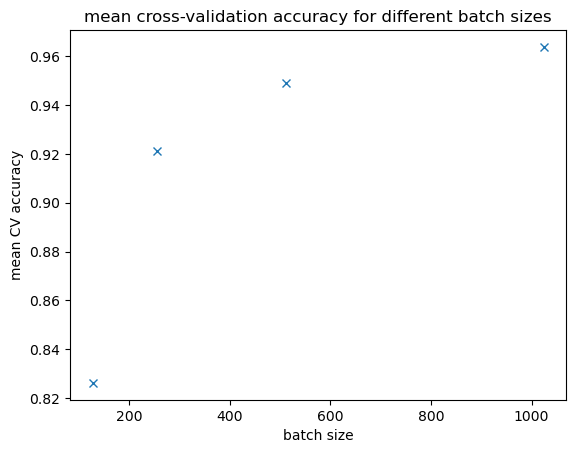

In [19]:
# YOUR CODE HERE
# plt.figure(1)
plt.plot(batch_sizes, cross_validation_accuracies, marker = 'x', linestyle = 'None')
plt.title('mean cross-validation accuracy for different batch sizes')
plt.xlabel('batch size')
plt.ylabel('mean CV accuracy')
plt.show()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [20]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Last Epoch Time': cross_validation_times
                  })

df

,Batch Size,Last Epoch Time
0,128,4.402659
1,256,2.493071
2,512,1.732165
3,1024,1.537086


In [21]:
# YOUR CODE HERE
optimal_batch_size = 1024
reason = "Lowest last epoch time and highest mean cross-validation accuracy"